# Introduction

In this notebook, we implement a Convolutional Neural Network (CNN) to classify images from the **Malaria dataset**,  containing 27,558 cell images with equal instances of **parasitized and uninfected cells** from the thin blood smear slide images of segmented cells. 

**Publication**: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html

**Statistics on the dataset:** https://knowyourdata-tfds.withgoogle.com/#dataset=malaria&tab=STATS&select=kyd%2Fmalaria%2Flabel

This code is an adapted version of Tensorflow official tutorial on CNNs.

file:///home/giulia/Projects/cnn_image_classif_malaria/malaria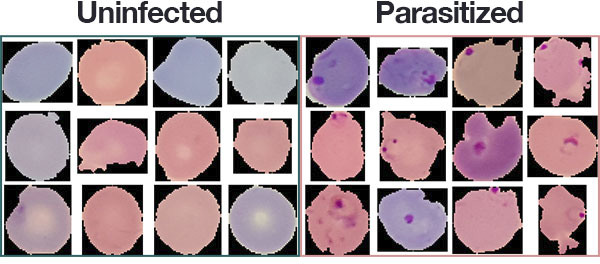

# Data import

In [34]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import datasets, layers, models


import numpy as np
import matplotlib.pyplot as plt

We build train and test datasets using the images in `data` directory of this project:
1. We first rescale pixels between 0 and 1 
2. Split between train and validation: 0.75/0.25
3. Build the train and test dataset using data in the directories

In [28]:
data_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0.25)

In [29]:
train_data_generator = data_gen.flow_from_directory(directory='./data',
                                                   target_size = (32, 32),
                                                   class_mode = 'binary',
                                                   batch_size = 16,
                                                   subset = 'training'
                                                   )

Found 20670 images belonging to 2 classes.


In [30]:
validation_data_generator = data_gen.flow_from_directory(directory='./data',
                                                   target_size = (32, 32),
                                                   class_mode = 'binary',
                                                   batch_size = 16,
                                                   subset = 'validation'
                                                   )

Found 6888 images belonging to 2 classes.


Data is labeled according to the classes 0: Uninfected, 1: Parasitized

In [31]:
train_data_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Each image has a size of 64 x 64 with 3 colours channels:

In [32]:
train_data_generator.image_shape

(32, 32, 3)

# CNN

## Building CNN

A CNN is composed by:
- a *convolution layer*, CONV: this layer uses filters to generate a feature map identifying different elements of the image: angles, vertical lines, horizontal lines etc.
- a *pooling layer*,POOL: uses the feature map of the previous layer and downsamples the input by splitting it in non overlapping rectangles of n pixels. The maximum (max pooling) or the mean is the taken
- *fully connected*,FC layer: operates on a flattened input where each input is connected to all neurons

In [35]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))) #1ère couche: fonction d'activation relu, kernel de dim 3x3
model.add(layers.MaxPooling2D((2, 2)))  #fenetre du sous-échantillon de taille 2x2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Here's our current network:

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


We add FC layer:

In [38]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

## Training the CNN

- we optimize the loss fonction using the Adam method.
- We choose the *cross-entropy loss* loss fonction
- Since the dataset is pretty balanced, we use the *accuracy* score as a mesure of performance

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
history = model.fit_generator(generator=train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 5,
                              validation_data = validation_data_generator,
                              validation_steps = len(validation_data_generator))

Epoch 1/5
1292/1292 [==============================] - 22s 17ms/step - loss: 0.1152 - accuracy: 0.9602 - val_loss: 0.1364 - val_accuracy: 0.9515
Epoch 2/5
1292/1292 [==============================] - 23s 18ms/step - loss: 0.1050 - accuracy: 0.9647 - val_loss: 0.1557 - val_accuracy: 0.9472
Epoch 3/5
1292/1292 [==============================] - 23s 18ms/step - loss: 0.0964 - accuracy: 0.9670 - val_loss: 0.1674 - val_accuracy: 0.9466
Epoch 4/5
1292/1292 [==============================] - 23s 18ms/step - loss: 0.0820 - accuracy: 0.9722 - val_loss: 0.1628 - val_accuracy: 0.9441
Epoch 5/5
1292/1292 [==============================] - 23s 18ms/step - loss: 0.0696 - accuracy: 0.9764 - val_loss: 0.1649 - val_accuracy: 0.9499


## Evaluation

In [46]:
history.history

{'loss': [0.115234375,
  0.10500162094831467,
  0.0963667780160904,
  0.08204251527786255,
  0.06963276118040085],
 'accuracy': [0.96018385887146,
  0.9647315144538879,
  0.9669569134712219,
  0.9722303152084351,
  0.9763908982276917],
 'val_loss': [0.1364286094903946,
  0.15566766262054443,
  0.16738931834697723,
  0.16282932460308075,
  0.16488289833068848],
 'val_accuracy': [0.9515098929405212,
  0.9471544623374939,
  0.9465737342834473,
  0.9441056847572327,
  0.9499129056930542]}

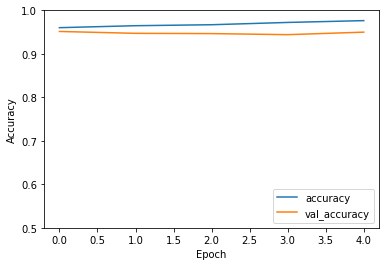

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We get about 95% of accuracy on the validation dataset.